# Introduction to The Bias-Variance-Tradeoff & Cross-Validation

Contact: drew.wilimitis@vumc.org <br>
Date: 12/21/2022

This Jupyter notebook is the first part of a collection of openly available notebooks released alongside our manuscript "Cross-Validation for Model Development and Evaluation in Healthcare: Practical Considerations and Applied Examples" **[1]**. 

Our open-source code base (https://github.com/drewwilimitis/Manifold-Learning) contains the Python code used to perform all the analytical experiments, pre-procesing, and generation of results for our case-studies with real-world healthcare data (MIMIC-III). 

This series of notebooks is meant to demonstrate best-practices for cross-validation with healthcare data and offer reproducible software functionality that might aid developers with various clinical machine learning problems.

**[1]** (insert manuscript link when published)

## Import Libraries

In [3]:
# import libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
from mlxtend.evaluate import bias_variance_decomp 

# set matplotlib style and plotting configuration
plt.style.use('seaborn')
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

# load models for plotting and try new plotting format
#from jupyterthemes import jtplot, get_themes
#jtplot.style(theme='grade3', context='notebook', ticks=True, grid=False)

**NOTE:** Two things we can estimate error of when it comes to CV (re-read) <br>

1. Estimate true prediction error using best model from CV with tuned parameters (in terms of classification metrics/MSE) on true hold-out set data <br>

2. An estimate (believe authors find this more convincing) of how if you repeated CV enough (say 5 fold) you'd eventually get an accurate estimate of how your CV models perform on hold out sets??

## Background

To set the framework for this applied tutorial on cross validation, we first introduce "Bias" and "Variance". These are the two primary sources of error associated with machine learning development and validation. We briefly provide the mathematical formulations of model bias and variance, however, it is rather the conceptual understanding that is paramount for intelligent design choices and responsible predictive modeling.

First we consider the predictive modeling process itself, ${\hat{f}}(X_i)$, as the process we hope to train in order to accurrately predict the true labels, $Y_i$, by learning from the original training data samples with their known labels: $D(X_i, Y_i)$. <br>

The last $\epsilon$ term represents uncontrollable, i.i.d variance terms with mean 0 and standard deviation 1 that we ignore as noise in the training data. We consider the problem of teaching ${\hat{f}}(X;D)$ by using a supervised learning algorithm to accurately predict the label $Y_i$ for a new instance outside the training sample.

The error in predicting a new label $Y_i$ after training ${\hat{f}}$ on all available data samples $D$ can be written as the mean squared error **(MSE)** between the true label $Y_i$ and the prediction made by ${\hat{f}}(X;D)$.<br>

This **Mean Squared Error (MSE)** can be broken down into three terms:<br>

<div class="alert" style="text-align:left; font-size:110%; color: #00FFF7">

<div class="alert" style='background-color: #00FFF7; color: #000000; border-left: solid #000000 6px; border-right: solid #000000 6px; border-top: solid #000000 4px; border-bottom: solid #000000 4px; border-radius: 4px; padding:1.8em;'>

<div style="text-align:right; font-size:120%;">
$${\displaystyle \operatorname {E} _{D,\varepsilon }{\Big [}{\big (}y-{\hat {f}}(x;D){\big )}^{2}{\Big ]}={\Big (}\operatorname {Bias} _{D}{\big [}{\hat {f}}(x;D){\big ]}{\Big )}^{2}+\operatorname {Var} _{D}{\big [}{\hat {f}}(x;D){\big ]}+\sigma^{2}}$$

<div class="warning" style='background-color:#F8F8FF; color: #000000; border-left: solid #000000 4px; border-right: solid #000000 4px; border-top: solid #000000 4px; border-bottom: solid #000000 4px; border-radius: 5px; padding:0.8em;'>

<div style="text-align:left; font-size:115%;">
<b>Tip:</b> Bias and Variance are often considered the two sources of error in machine learning. </div>

<p style='text-align:left; color: #000000;'>
1. <b>Bias</b> $\ = {\Big (}\operatorname {Bias} _{D}{\big [}{\hat {f}}(x;D){\big ]}{\Big )}^{2}$ </p>
    
<p style='text-align:left; color: #000000;'>
2. <b>Variance</b> $\ = \operatorname {Var} _{D}{\big [}{\hat {f}}(x;D){\big ]}$ <br>

**Note**: Imperfect training data is considered inevitable which leads to *i.i.d.* variance terms: $ \ \epsilon_{1} ^ {2} . . . \epsilon_{n}^{2} \ $ with $\mu_{i}=0, \ \sigma_{i}=1$ </div>

<div style="text-align:center; font-size:125%;">
    
 **From lecture notes found here:** <br>
    
https://www.it.uu.se/edu/course/homepage/sml/lectures/lecture5_handout.pdf
    
___

\begin{equation}
\mathcal{T}=\left\{\left(x_i, y_i\right)\right\}_{i=1}^n
\end{equation}

\begin{equation}
E_{\text {train }}=\frac{1}{n} \sum_{i=1}^n E\left(\widehat{y}\left(\mathbf{x}_i\right), y_i\right)
\end{equation}

\begin{equation}
E_{\text {new }} \approx E_{\mathrm{hold}-\mathrm{out}}=\frac{1}{n_v} \sum_{i=1}^{n_v} E\left(\widehat{y}\left(\mathbf{x}_i ; \mathcal{T}\right), y_i\right)
\end{equation}

\begin{equation}
E_{\text {new }} \approx E_{\mathrm{k} \text {-fold }}=\frac{1}{k} \sum_{\ell=1}^k E_{\mathrm{hold}-\mathrm{out}}^{(\ell)}
\end{equation}

\begin{equation}
E_{\text {new }} \approx E_{\text {hold-out }}=\frac{1}{n_v} \sum_{i=1}^{n_v} E\left(\widehat{y}\left(\mathbf{x}_i ; \mathcal{T}\right), y_i\right)
\end{equation}

\begin{equation}
\begin{aligned}
\bar{E}_{\text {train }} &=\mathbb{E}_{\mathcal{T}}\left[E_{\text {train }}\right] \\
\\ \bar{E}_{\text {new }} &=\mathbb{E}_{\mathcal{T}}\left[E_{\text {new }}\right] \\
\end{aligned}
\end{equation} \\

\\
\begin{equation}
    E_{\text {new }}=\mathbb{E}_{\star}\left[E\left(\widehat{y}\left(x_{\star}\right), y_{\star}\right)\right]
\end{equation}

____
<div style="text-align:center; font-size:120%;">

**From ESTL Text book below:**
____
    
Given a specific training set $\mathcal{T}$, the generalization error of a model $\hat{f}$ is
<br>
    
$$\operatorname{Err}_{\mathcal{T}}=\mathrm{E}_{X^0, Y^0}\left[L\left(Y^0, \hat{f}\left(X^0\right)\right) \mid \mathcal{T}\right]$$

Note that the training set $\mathcal{T}$ is fixed. The point $\left(X^0, Y^0\right)$
is a new test data point, drawn from $F$, the joint distribution of the data. Averaging over all training sets $\mathcal{T}$ yields the expected error

$$
\operatorname{Err}=\mathrm{E}_{\mathcal{T}} \mathrm{E}_{X^0, Y^0}\left[L\left(Y^0, \hat{f}\left(X^0\right)\right) \mid \mathcal{T}\right]
$$

Test error, also referred to as generalization error, is the prediction error
over an independent test sample <br>

\begin{equation}
\operatorname{Err}_{\mathcal{T}}=\mathrm{E}[L(Y, \hat{f}(X)) \mid \mathcal{T}]
\end{equation}
<br>
Here $\mathcal{T}$ if a fixed training set, and test error refers to the error from this specific training set

The following is the *expected* test error, defined by averaging over randomness involved (including the specific training set used)<br>
<br>    

\begin{equation}
\operatorname{Err}=\mathrm{E}[L(Y, \hat{f}(X))]=\mathrm{E}\left[\operatorname{Err}_{\mathcal{T}}\right]
\end{equation} <br>


\begin{equation}
\overline{\mathrm{err}}=\frac{1}{N} \sum_{i=1}^N L\left(y_i, \hat{f}\left(x_i\right)\right)
\end{equation}

\begin{equation}
\operatorname{Err}_{\mathrm{in}}=\frac{1}{N} \sum_{i=1}^N \mathrm{E}_{Y^0}\left[L\left(Y_i^0, \hat{f}\left(x_i\right)\right) \mid \mathcal{T}\right]
\end{equation}

\textbf{Algorithm 1}
---
**Inputs:** Given a Network $G=(V,E)$ with flow capacity $c$, a source node $s$, and a sink node $t$

**Output:** Compute a flow $f$ from $s$ to $t$ of maximum value

1. $f(u, v) \leftarrow 0$ for all edges $(u,v)$
2. While there is a path $p$ from $s$ to $t$ in $G_{f}$ such that $c_{f}(u,v)>0$
	for all edges $(u,v) \in p$:

	1. Find $c_{f}(p)= \min \{c_{f}(u,v):(u,v)\in p\}$
	2. For each edge $(u,v) \in p$

		1. $f(u,v) \leftarrow f(u,v) + c_{f}(p)$ *(Send flow along the path)*
		2. $f(u,v) \leftarrow f(u,v) - c_{f}(p)$ *(The flow might be "returned" later)* -->

\textbf{Algorithm 1}
---
    err -> 0
    for i = 1, ..., N:
    // define the cross-validation subsets
          x_in ← (x[1], ..., x[i − 1], x[i + 1], ..., x[N])
          y_in ← (y[1], ..., y[i − 1], y[i + 1], ..., y[N])
          x_out ← x[i]
          y_out ← interpolate(x_in, y_in, x_out)
          err ← err + (y[i] − y_out)^2
    end for
    err -> err/N

## Visualizing Bias-Variance-Tradeoff 

With simple graphical examples below, we attempt to motivate and exemplify the "Bias-variance- tradeoff"" as related to supervised machine learning

### Linear Regression with Polynomial Features

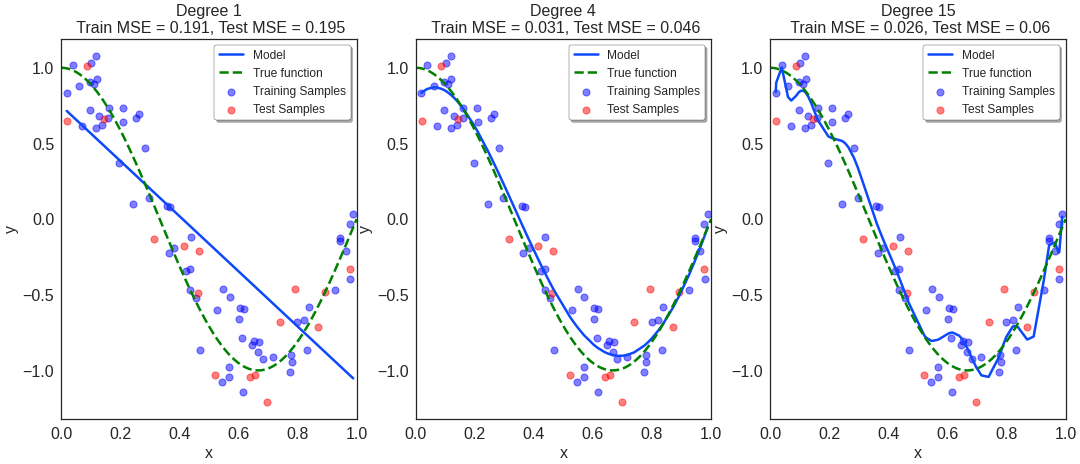

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

def true_fun(X):
    return np.cos(1.5 * np.pi * X)
np.random.seed(0)
n_samples = 80
degrees = [1, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

plt.figure(figsize=(18, 7))
plt.style.use(['science', 'notebook', 'high-vis'])
plt.style.use('seaborn-white')

for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression),
        ]
    )
    pipeline.fit(X_train[:, np.newaxis], y_train)
    X_grid = np.linspace(0, 1, 100)
    plt.plot(X, pipeline.predict(X[:, np.newaxis]), label="Model", linewidth=2.5)
    plt.plot(X_grid, true_fun(X_grid), label="True function", color='green', linewidth=2.5)
    plt.scatter(X_train, y_train, color='blue', s=50, alpha=0.5, linewidth=1, label="Training Samples")
    plt.scatter(X_test, y_test, color='red', s=50, alpha=0.5, linewidth=1, label="Test Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    #plt.ylim((-2, 2))
    plt.legend(loc="best", frameon=True, edgecolor='black', shadow=True, fontsize=12)
    #plt.grid(True)
    
    train_mse = mean_squared_error(y_pred=pipeline.predict(X_train.reshape(-1,1)), y_true=y_train)
    test_mse = mean_squared_error(y_pred=pipeline.predict(X_test.reshape(-1,1)), y_true=y_test)
    plt.title("Degree {}\n Train MSE = {}, Test MSE = {}".format(degrees[i],
                                                                 round(train_mse, 3),
                                                                 round(test_mse, 3)))
plt.show();

In [5]:
# get train/test errors and bias-variances for same dataset with varying polynomial degrees
train_errors = []
test_errors = []
avg_mses = []
avg_biases = []
avg_vars = []
degrees = np.arange(1, 15, 1)
for i in range(len(degrees)):
    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression),
        ]
    )
    pipeline = pipeline.fit(X_train[:, np.newaxis], y_train)
    train_mse = mean_squared_error(y_pred=pipeline.predict(X_train.reshape(-1,1)), y_true=y_train)
    test_mse = mean_squared_error(y_pred=pipeline.predict(X_test.reshape(-1,1)), y_true=y_test)
    train_errors.append(train_mse)
    test_errors.append(test_mse);
    
    # get avg expected mse, bias, variances
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(pipeline,
                                                                X_train=X_train.reshape(-1,1),
                                                                X_test=X_test.reshape(-1,1),
                                                                y_test=y_test,
                                                                y_train=y_train,
                                                                loss='mse',
                                                                num_rounds=5)
    avg_mses.append(avg_expected_loss)
    avg_biases.append(avg_bias)
    avg_vars.append(avg_var)

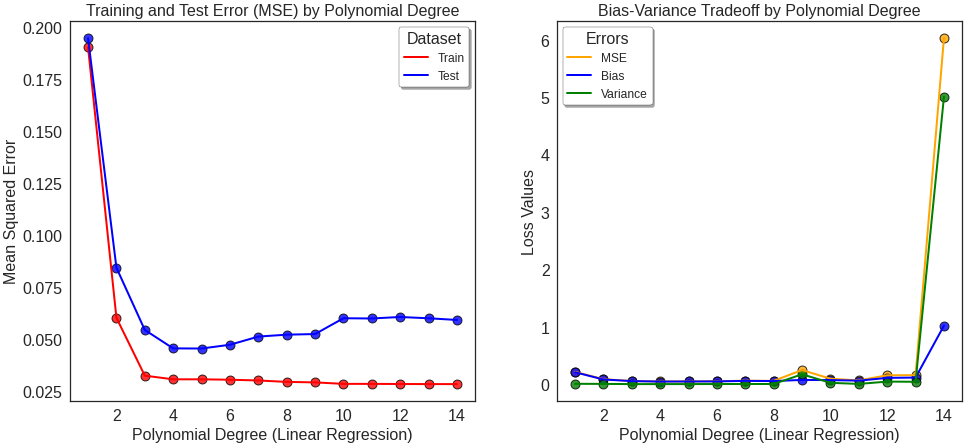

In [7]:
# plot MSE by training and testing dataset by polynomial degree
plt.style.reload_library()
plt.style.use(['science', 'notebook', 'std-colors'])
plt.style.use('seaborn-white')
plt.figure(figsize=(16, 7))

# plot MSE by training and test sets
plt.subplot(121)
plt.plot(degrees, train_errors, linewidth=2, color='red', label='Train')
plt.scatter(degrees, train_errors, s=80, alpha=0.8, edgecolor='black', linewidth=1, color='red')
plt.plot(degrees, test_errors, linewidth=2, color='blue', label='Test')
plt.scatter(degrees, test_errors, s=80, alpha=0.8, edgecolor='black', linewidth=1, color='blue')
plt.ylabel('Mean Squared Error')
plt.xlabel('Polynomial Degree (Linear Regression)')
plt.legend(frameon=True, edgecolor='black', shadow=True, fontsize=12, title='Dataset')
plt.title('Training and Test Error (MSE) by Polynomial Degree')

# plot bias-variance tradeoff
plt.subplot(122)
plt.plot(degrees, avg_mses, linewidth=2, color='orange', label='MSE')
plt.scatter(degrees, avg_mses, s=80, alpha=0.8, edgecolor='black', linewidth=1, color='orange')
plt.plot(degrees, avg_biases, linewidth=2, color='blue', label='Bias')
plt.scatter(degrees, avg_biases, s=80, alpha=0.8, edgecolor='black', linewidth=1, color='blue')
plt.plot(degrees, avg_vars, linewidth=2, color='green', label='Variance')
plt.scatter(degrees, avg_vars, s=80, alpha=0.8, edgecolor='black', linewidth=1, color='green')
plt.ylabel('Loss Values')
plt.xlabel('Polynomial Degree (Linear Regression)')
plt.legend(frameon=True, edgecolor='black', shadow=True, fontsize=12, title='Errors')
plt.title('Bias-Variance Tradeoff by Polynomial Degree')
#plt.savefig('../plots/Intro_Bias_Variance/MSE_AND_BIAS_VARIANCE_LINEAR_REGRESSION_POLYNOMIAL_DEGREES.png', dpi=300)
plt.show();

- As polynomial degree (model complexity) increases, the training error decreases but the test error increases after degree=4 (overfitting)
- For degree < 4, increasing complexity improves test error (underfit)
- Relatedly, variance increases dramatically for higher degrees (overfitting to training data)
- Bias decreases and remains constant until higher degrees 

### Test Bias/Variance by Hyperparameters

In [49]:
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# load boston dataset
X, y = load_boston(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# get train/test errors and bias-variances for same dataset with varying max depth
train_errors = []
test_errors = []
avg_mses = []
avg_biases = []
avg_vars = []
max_depth = np.arange(1, 61, 2)
for depth in max_depth:
    clf = DecisionTreeRegressor(max_depth=depth)
    clf = clf.fit(X_train, y_train)
    train_mse = mean_squared_error(y_pred=clf.predict(X_train), y_true=y_train)
    test_mse = mean_squared_error(y_pred=clf.predict(X_test), y_true=y_test)
    train_errors.append(train_mse)
    test_errors.append(test_mse)
    
    # get avg expected mse, bias, variances
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(clf,
                                                                X_train=X_train,
                                                                X_test=X_test,
                                                                y_test=y_test,
                                                                y_train=y_train,
                                                                loss='mse',
                                                                num_rounds=10)
    avg_mses.append(avg_expected_loss)
    avg_biases.append(avg_bias)
    avg_vars.append(avg_var)

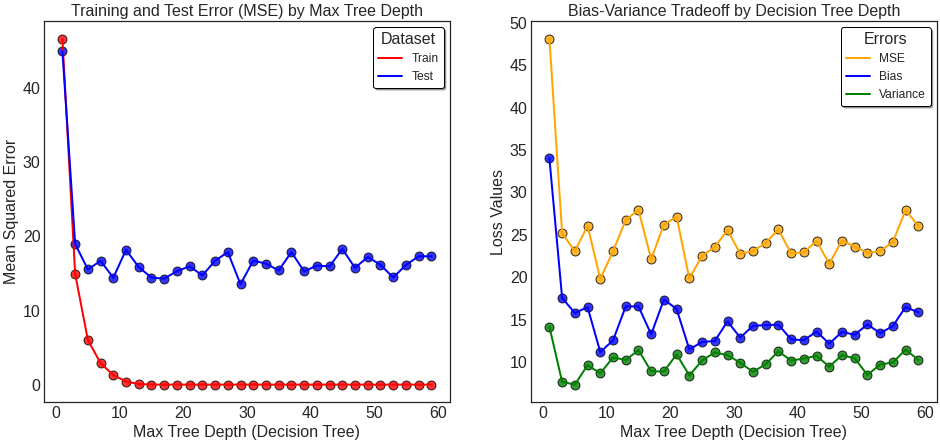

In [50]:
plt.style.use(['science', 'notebook', 'std-colors'])
plt.style.use('seaborn-white')
plt.figure(figsize=(16, 7))

# plot MSE by training and test sets
plt.subplot(121)
plt.plot(max_depth, train_errors, linewidth=2, color='red', label='Train')
plt.scatter(max_depth, train_errors, s=80, alpha=0.8, edgecolor='black', linewidth=1, color='red')
plt.plot(max_depth, test_errors, linewidth=2, color='blue', label='Test')
plt.scatter(max_depth, test_errors, s=80, alpha=0.8, edgecolor='black', linewidth=1, color='blue')
plt.ylabel('Mean Squared Error')
plt.xlabel('Max Tree Depth (Decision Tree)')
plt.legend(frameon=True, edgecolor='black', shadow=True, fontsize=12, title='Dataset')
plt.title('Training and Test Error (MSE) by Max Tree Depth')

# plot bias-variance tradeoff
plt.subplot(122)
plt.plot(max_depth, avg_mses, linewidth=2, color='orange', label='MSE')
plt.scatter(max_depth, avg_mses, s=80, alpha=0.8, edgecolor='black', linewidth=1, color='orange')
plt.plot(max_depth, avg_biases, linewidth=2, color='blue', label='Bias')
plt.scatter(max_depth, avg_biases, s=80, alpha=0.8, edgecolor='black', linewidth=1, color='blue')
plt.plot(max_depth, avg_vars, linewidth=2, color='green', label='Variance')
plt.scatter(max_depth, avg_vars, s=80, alpha=0.8, edgecolor='black', linewidth=1, color='green')
plt.ylabel('Loss Values')
plt.xlabel('Max Tree Depth (Decision Tree)')
plt.legend(frameon=True, edgecolor='black', shadow=True, fontsize=12, title='Errors')
plt.title('Bias-Variance Tradeoff by Decision Tree Depth')
#plt.savefig('../plots/Intro_Bias_Variance/MSE_AND_BIAS_VARIANCE_DECISION_TREE_REGRESSION_MAX_DEPTH.png', dpi=300)
plt.show();

- As maximum tree depth increases, training error eventually approaches 0 (overfit)
- However, test error remains relatively constant as depth increases (likely due to size/dimension of dataset)
- Likely due to the dataset and features, the variance and bias decrease until a depth of 10 then remain constant

In [51]:
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# load boston dataset
X, y = load_boston(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# get train/test errors and bias-variances for same dataset with varying max depth
train_errors = []
test_errors = []
avg_mses = []
avg_biases = []
avg_vars = []
n_trees = np.arange(1, 100, 5)
for n in n_trees:
    clf = RandomForestRegressor(n_estimators=n)
    clf = clf.fit(X_train, y_train)
    train_mse = mean_squared_error(y_pred=clf.predict(X_train), y_true=y_train)
    test_mse = mean_squared_error(y_pred=clf.predict(X_test), y_true=y_test)
    train_errors.append(train_mse)
    test_errors.append(test_mse)
    
    # get avg expected mse, bias, variances
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(clf,
                                                                X_train=X_train,
                                                                X_test=X_test,
                                                                y_test=y_test,
                                                                y_train=y_train,
                                                                loss='mse',
                                                                num_rounds=10)
    avg_mses.append(avg_expected_loss)
    avg_biases.append(avg_bias)
    avg_vars.append(avg_var)

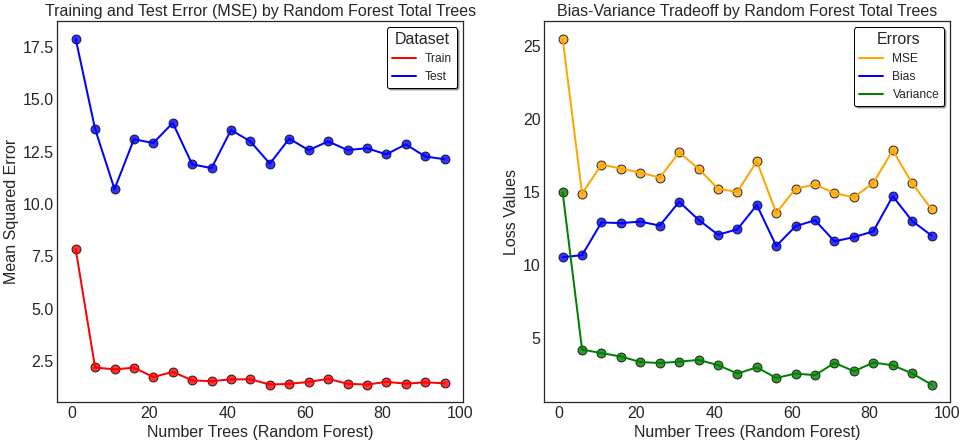

In [55]:
plt.style.use(['science', 'notebook', 'std-colors'])
plt.style.use('seaborn-white')
plt.figure(figsize=(16, 7))

# plot MSE by training and test sets
plt.subplot(121)
plt.plot(n_trees, train_errors, linewidth=2, color='red', label='Train')
plt.scatter(n_trees, train_errors, s=80, alpha=0.8, edgecolor='black', linewidth=1, color='red')
plt.plot(n_trees, test_errors, linewidth=2, color='blue', label='Test')
plt.scatter(n_trees, test_errors, s=80, alpha=0.8, edgecolor='black', linewidth=1, color='blue')
plt.ylabel('Mean Squared Error')
plt.xlabel('Number Trees (Random Forest)')
plt.legend(frameon=True, edgecolor='black', shadow=True, fontsize=12, title='Dataset')
plt.title('Training and Test Error (MSE) by Random Forest Total Trees')

# plot bias-variance tradeoff
plt.subplot(122)
plt.plot(n_trees, avg_mses, linewidth=2, color='orange', label='MSE')
plt.scatter(n_trees, avg_mses, s=80, alpha=0.8, edgecolor='black', linewidth=1, color='orange')
plt.plot(n_trees, avg_biases, linewidth=2, color='blue', label='Bias')
plt.scatter(n_trees, avg_biases, s=80, alpha=0.8, edgecolor='black', linewidth=1, color='blue')
plt.plot(n_trees, avg_vars, linewidth=2, color='green', label='Variance')
plt.scatter(n_trees, avg_vars, s=80, alpha=0.8, edgecolor='black', linewidth=1, color='green')
plt.ylabel('Loss Values')
plt.xlabel('Number Trees (Random Forest)')
plt.legend(frameon=True, edgecolor='black', shadow=True, fontsize=12, title='Errors')
plt.title('Bias-Variance Tradeoff by Random Forest Total Trees')
#plt.savefig('../plots/Intro_Bias_Variance/MSE_AND_BIAS_VARIANCE_RANDOM_FOREST_REGRESSION_N_TREES.png', dpi=300)
plt.show();

- Here we also have overfitting and lower variance with higher number of trees (higher complexity)
- Bias slightly increases with more trees, but for this dataset biggest chances occur from 0-10 trees

### Bias-Variance Tradeoff for K-NN Classification

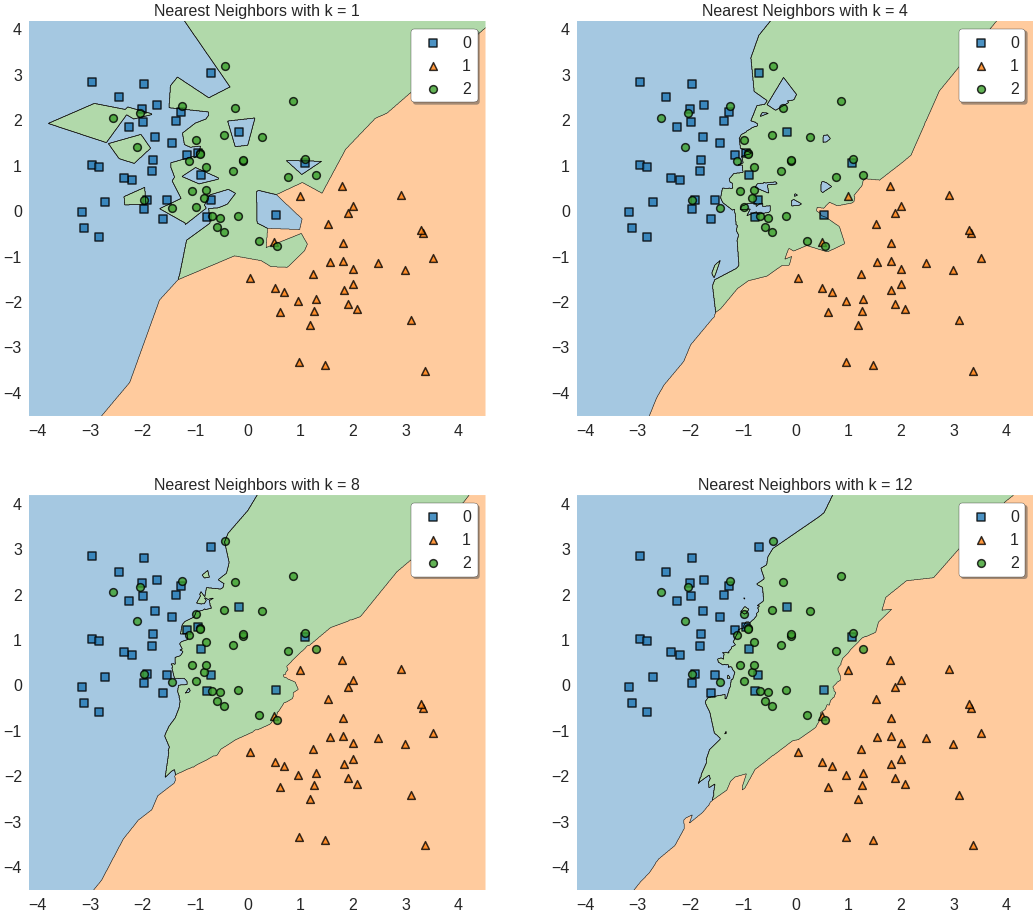

In [104]:
# try with K-NN with various value for k
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from mlxtend.evaluate import bias_variance_decomp
import matplotlib.gridspec as gridspec
import itertools
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.data import iris_data
from mlxtend.plotting import plot_decision_regions
from mlxtend.plotting import decision_regions
from sklearn.datasets import make_blobs, make_moons

# make synthetic classification dataset
X, y = make_blobs(n_samples=100, centers=3, center_box=(-2, 2), cluster_std=1, shuffle=True)

# plotting decision regions (using mlxtend library)
plt.style.reload_library()
plt.style.use(['science', 'notebook', 'std-colors'])
plt.style.use('seaborn-white')
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(18, 16))

# define classifiers with k values
k_values = [1, 4, 8, 12]
labels = ['Nearest Neighbors with k = ' + str(k) for k in k_values]
clfs = [KNeighborsClassifier(n_neighbors=k, n_jobs=-1, algorithm='kd_tree') for k in k_values]

# iterate and plot subplots for each value of k
for clf, lab, grd in zip(clfs,
                         labels,
                         itertools.product([0, 1],
                         repeat=2)):
    # fit classifier
    clf.fit(X, y)
    
    # specify keyword arguments to be passed to underlying plotting functions
    scatter_kwargs = {'s': 60, 'edgecolor': 'black', 'linewidth': 1.5, 'alpha': 0.8}
    contourf_kwargs = {'alpha': 0.4}
    #scatter_highlight_kwargs = {'s': 120, 'alpha': 0.7}
    
    # plot each subplot decision boundary
    ax = plt.subplot(gs[grd[0], grd[1]])
    plot_decision_regions(X=X, y=y, clf=clf, legend=2, ax=ax, scatter_kwargs=scatter_kwargs, contourf_kwargs=contourf_kwargs)
    plt.legend(frameon=True, edgecolor='black', shadow=True, loc='best')
    plt.title(lab)
        
#plt.savefig('../plots/Intro_Bias_Variance/KNN_CLASSIFICATION_PLOT_DECISION_REGIONS_2x2_GRID.png', dpi=300)
plt.show();

In [210]:
# get train/test errors and bias-variances with varying k-values
from sklearn.metrics import zero_one_loss

# make synthetic classification dataset (different from shown above)
X, y = make_blobs(n_samples=200, centers=3, center_box=(-2, 2), cluster_std=1, shuffle=True)
X, y = make_moons(n_samples=200, noise=0.5, shuffle=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)
train_errors = []
test_errors = []
avg_losses = []
avg_biases = []
avg_vars = []
k_values = np.arange(1, 31, 1)
for k in k_values:
    clf = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    clf = clf.fit(X_train, y_train)
    train_loss = zero_one_loss(y_pred=clf.predict(X_train), y_true=y_train)
    test_loss = zero_one_loss(y_pred=clf.predict(X_test), y_true=y_test)
    train_errors.append(train_loss)
    test_errors.append(test_loss)
    
    # get avg expected mse, bias, variances
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(clf,
                                                                X_train=X_train,
                                                                X_test=X_test,
                                                                y_test=y_test,
                                                                y_train=y_train,
                                                                loss='0-1_loss',
                                                                num_rounds=10)
    avg_losses.append(avg_expected_loss)
    avg_biases.append(avg_bias)
    avg_vars.append(avg_var)

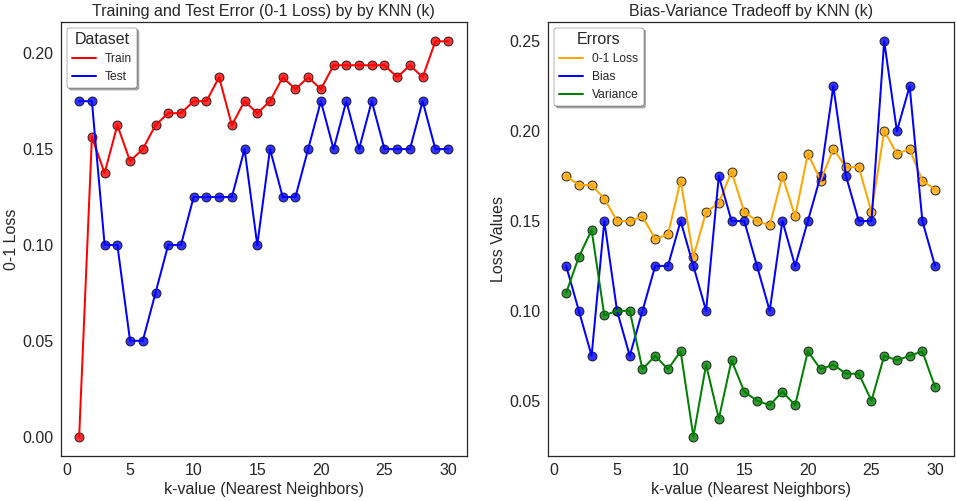

In [212]:
plt.style.use(['science', 'notebook', 'std-colors'])
plt.style.use('seaborn-white')
plt.figure(figsize=(16, 8))

# plot MSE by training and test sets
plt.subplot(121)
plt.plot(k_values, train_errors, linewidth=2, color='red', label='Train')
plt.scatter(k_values, train_errors, s=80, alpha=0.8, edgecolor='black', linewidth=1, color='red')
plt.plot(k_values, test_errors, linewidth=2, color='blue', label='Test')
plt.scatter(k_values, test_errors, s=80, alpha=0.8, edgecolor='black', linewidth=1, color='blue')
plt.ylabel('0-1 Loss')
plt.xlabel('k-value (Nearest Neighbors)')
plt.legend(frameon=True, edgecolor='black', shadow=True, fontsize=12, title='Dataset')
plt.title('Training and Test Error (0-1 Loss) by by KNN (k)')

# plot bias-variance tradeoff
plt.subplot(122)
plt.plot(k_values, avg_losses, linewidth=2, color='orange', label='0-1 Loss')
plt.scatter(k_values, avg_losses, s=80, alpha=0.8, edgecolor='black', linewidth=1, color='orange')
plt.plot(k_values, avg_biases, linewidth=2, color='blue', label='Bias')
plt.scatter(k_values, avg_biases, s=80, alpha=0.8, edgecolor='black', linewidth=1, color='blue')
plt.plot(k_values, avg_vars, linewidth=2, color='green', label='Variance')
plt.scatter(k_values, avg_vars, s=80, alpha=0.8, edgecolor='black', linewidth=1, color='green')
plt.ylabel('Loss Values')
plt.xlabel('k-value (Nearest Neighbors)')
plt.legend(frameon=True, edgecolor='black', shadow=True, fontsize=12, title='Errors')
plt.title('Bias-Variance Tradeoff by KNN (k)')
#plt.savefig('../plots/Intro_Bias_Variance/LOSS_BIAS_VARIANCE_TRAIN_TEST_KNN_K_Values.png', dpi=300)
plt.show();

- From the decision boundaries above, KNN with small k has jagged boundaries (over-fitting)
- As k increases, decision boundaries become smoother (under-fitting)
- Therefore, as k increases the variance decreases and the bias increases
- For k=1, the error on the training set is nearly perfect (overfit) but test error is optimal around k=5

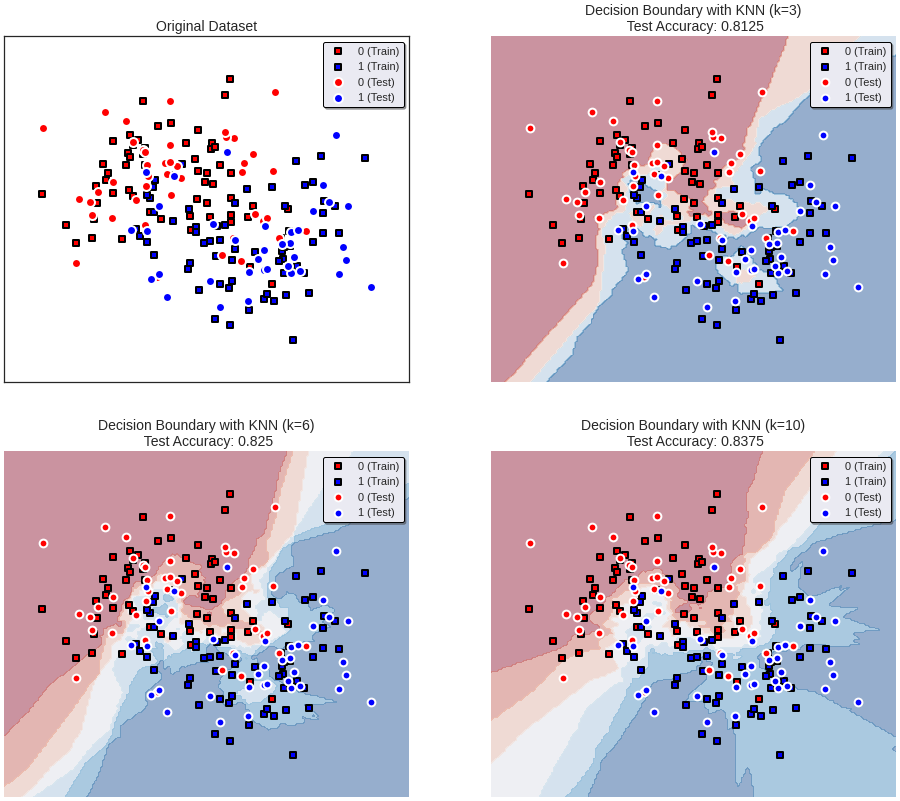

In [2]:
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from mlxtend.evaluate import bias_variance_decomp
import matplotlib.gridspec as gridspec
import itertools
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.data import iris_data
from mlxtend.plotting import plot_decision_regions
from mlxtend.plotting import decision_regions
from sklearn.datasets import make_blobs, make_moons

X, y = make_moons(n_samples=200, noise=0.4, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])

plt.style.reload_library()
plt.style.use(['science', 'notebook', 'std-colors'])
plt.style.use('seaborn-white')

fig = plt.figure(figsize=(16,14))

# just plot the dataset first
plt.subplot(221)
plt.style.use('seaborn-darkgrid')

# plot the training points
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c="#FF0000",
           linewidths=2.0, edgecolors="black", marker='s', label='0 (Train)')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c="#0000FF",
           linewidths=2.0, edgecolors="black", marker='s', label='1 (Train)')

# plot the testing points
plt.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], c="#FF0000",
           linewidths=2.0, s=80, edgecolors="white", marker='o', label='0 (Test)')
plt.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], c="#0000FF",
           linewidths=2.0, s=80, edgecolors="white", marker='o', label='1 (Test)')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.legend(frameon=True, shadow=True, edgecolor='black', fontsize=11)
plt.gca().grid(True)
plt.title('Original Dataset', size=14)

# iterate over classifiers
clf = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
clf = make_pipeline(StandardScaler(), clf)
clf = clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)

# plot decision boundary
plt.subplot(222)
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(clf, X, cmap=cm, alpha=0.4, ax=ax, s=0.5,
                                       eps=0.5, grid_resolution=200)

# Plot the training points
ax.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c="#FF0000", cmap=cm_bright,
           linewidths=2.0, edgecolors="black", marker='s', label='0 (Train)')
ax.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c="#0000FF", cmap=cm_bright,
           linewidths=2.0, edgecolors="black", marker='s', label='1 (Train)')

# Plot the testing points
ax.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], c="#FF0000", cmap=cm_bright,
           linewidths=2.0, s=60, edgecolors="white", marker='o', label='0 (Test)')
ax.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], c="#0000FF", cmap=cm_bright,
           linewidths=2.0, s=60, edgecolors="white", marker='o', label='1 (Test)')

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())
plt.legend(frameon=True, shadow=True, edgecolor='black', fontsize=11)
plt.title('Decision Boundary with KNN (k=3)\n Test Accuracy: {}'.format(score), size=14)

# iterate over classifiers
clf = KNeighborsClassifier(n_neighbors=6, n_jobs=-1)
clf = make_pipeline(StandardScaler(), clf)
clf = clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)

# plot decision boundary
plt.subplot(223)
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(clf, X, cmap=cm, alpha=0.4, ax=ax, s=0.5,
                                       eps=0.5, grid_resolution=200)

# Plot the training points
ax.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c="#FF0000", cmap=cm_bright,
           linewidths=2.0, edgecolors="black", marker='s', label='0 (Train)')
ax.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c="#0000FF", cmap=cm_bright,
           linewidths=2.0, edgecolors="black", marker='s', label='1 (Train)')

# Plot the testing points
ax.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], c="#FF0000", cmap=cm_bright,
           linewidths=2.0, s=60, edgecolors="white", marker='o', label='0 (Test)')
ax.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], c="#0000FF", cmap=cm_bright,
           linewidths=2.0, s=60, edgecolors="white", marker='o', label='1 (Test)')

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())
plt.legend(frameon=True, shadow=True, edgecolor='black', fontsize=11)
plt.title('Decision Boundary with KNN (k=6)\n Test Accuracy: {}'.format(score), size=14)

# iterate over classifiers
clf = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
clf = make_pipeline(StandardScaler(), clf)
clf = clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)

# plot decision boundary
plt.subplot(224)
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(clf, X, cmap=cm, alpha=0.4, ax=ax, s=0.5,
                                       eps=0.5, grid_resolution=200)

# Plot the training points
ax.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c="#FF0000", cmap=cm_bright,
           linewidths=2.0, edgecolors="black", marker='s', label='0 (Train)')
ax.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c="#0000FF", cmap=cm_bright,
           linewidths=2.0, edgecolors="black", marker='s', label='1 (Train)')

# Plot the testing points
ax.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], c="#FF0000", cmap=cm_bright,
           linewidths=2.0, s=60, edgecolors="white", marker='o', label='0 (Test)')
ax.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], c="#0000FF", cmap=cm_bright,
           linewidths=2.0, s=60, edgecolors="white", marker='o', label='1 (Test)')

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())
plt.legend(frameon=True, shadow=True, edgecolor='black', fontsize=11)
plt.title('Decision Boundary with KNN (k=10)\n Test Accuracy: {}'.format(score), size=14)
#plt.savefig('../plots/Intro_Bias_Variance/KNN_DECISION_BOUNDARY_TRAIN_TEST_K_VALUES_GRID.png', dpi=300)
plt.show();

## Bias & Variance for Cross-Validation

In [ ]:
# from sklearn.model_selection import KFold, StratifiedKFold, LeaveOneOut, RepeatedKFold, RepeatedStratifiedKFold
# from sklearn.model_selection import cross_validate
# from sklearn.datasets import load_boston, load_iris, load_breast_cancer
# X, y = load_breast_cancer(return_X_y=True)
# kf = KFold(n_splits=5, shuffle=True, random_state=8888)
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=8888)
# loo = LeaveOneOut()
# repeated_kf = RepeatedKFold(n_repeats=10, n_splits=5, random_state=8888)
# repeated_skf = RepeatedStratifiedKFold(n_repeats=100, n_splits=5, random_state=8888)
# cv_methods = [kf, skf, loo, repeated_kf, repeated_skf]
# cv_names = ['KFold', 'StratifiedKFold', 'LeaveOneOut', 'RepeatedKFold', 'RepeatedStratifiedKFold']
# cv_types = dict(zip(cv_names, cv_methods))

# clf = LogisticRegression(max_iter=1000)
# rf = RandomForestRegressor(n_estimators=1, n_jobs=-1)
# # for train, test in kf.split(X):
# #     X_train = X[train]
# #     y_train = y[train]
# #     X_test = X[test]
# #     y_test = y[test]
# #     clf.fit(X_train, y_train)
# cv_dict = {}
# cv_dfs = []
# for name, split_fn in cv_types.items():
#     cv = cross_validate(rf, X, y, cv=split_fn, n_jobs=-1, scoring='accuracy')
#     cv_dict[name] = cv
#     df = pd.DataFrame(cv)
#     df['method'] = name
#     cv_dfs.append(df)

# cv_results = pd.concat(cv_dfs)
# plt.style.use('seaborn-whitegrid')
# plt.style.use('bmh')
# sns.set_palette('bright')
# plt.figure(figsize=(14,6))
# plt.subplot(121)
# sns.boxplot(data=cv_results, x='method', y='test_score', hue='method', dodge=False, width=0.5, whis=2.5)
# plt.legend(frameon=True, edgecolor='black', shadow=True, fontsize=11, title='CV Method')
# plt.xticks([])
# plt.xlabel('')
# plt.subplot(122)
# sns.boxplot(data=cv_results, x='method', y='fit_time', hue='method', dodge=False, width=0.5, whis=2.5)
# plt.legend(frameon=True, edgecolor='black', shadow=True, fontsize=11, title='CV Method')
# plt.xticks([])
# plt.xlabel('')
# plt.show();

# from sklearn.datasets import load_boston
# from sklearn.linear_model import LinearRegression
# X, y = load_boston(return_X_y=True)
# #X = X.reshape(1,-1)
# clf = LinearRegression(n_jobs=-1)
# avg_bias = []
# avg_expected_loss = []
# avg_var = []
# cv_dict = {}
# cv_dfs = []
# for name, split_fn in cv_types.items():
#     if 'Stratified' in name:
#         continue
#     cv_dict[name] = {}
#     avg_bias = []
#     avg_expected_loss = []
#     avg_var = []
#     for train, test in split_fn.split(X, y):
#         X_train = X[train]
#         y_train = y[train]
#         X_test = X[test]
#         y_test = y[test]
#         _ = clf.fit(X_train, y_train)
#         pred_y = clf.predict(X_test)
#         mses.append(mean_squared_error(y_test, pred_y))
#         resids.append(np.abs(y_test - pred_y))
#         err = bias_variance_decomp(clf, X_train, y_train, X_test, y_test, loss='mse')
#         avg_expected_loss.append(err[0])
#         avg_bias.append(err[1])
#         avg_var.append(err[2])
#     cv_dict[name]['avg_loss'] = avg_expected_loss
#     cv_dict[name]['avg_bias'] = avg_bias
#     cv_dict[name]['avg_var'] = avg_var

# kf_bias = cv_dict['KFold']['avg_bias']
# kf_var = cv_dict['KFold']['avg_var']

# repeated_kf_bias = cv_dict['RepeatedKFold']['avg_bias']
# repeated_kf_var = cv_dict['RepeatedKFold']['avg_var']

# loo_bias = cv_dict['LeaveOneOut']['avg_bias']
# loo_var = cv_dict['LeaveOneOut']['avg_var']

# error_df = pd.DataFrame(np.array(kf_bias + repeated_kf_bias + loo_bias), columns=['avg_bias'])
# error_df['method'] = list(np.repeat('KFold', 5)) + list(np.repeat('RepeatedKFold', 50)) + list(np.repeat('LeaveOneOut', 506))
# error_df['avg_variance'] = np.array(kf_var + repeated_kf_var + loo_var)
# error_df

# plt.style.reload_library()
# plt.style.use('seaborn-whitegrid')
# plt.style.use('bmh')
# sns.set_palette('tab10')
# plt.figure(figsize=(14,7))
# plt.subplot(121)
# sns.boxplot(data=error_df, x='method', y='avg_bias', hue='method', dodge=False, width=0.5, showfliers=False)
# plt.legend(frameon=True, edgecolor='black', shadow=True, facecolor='white', fontsize=12)
# #plt.xticks([])
# plt.xlabel('Cross Validation Method', size=12)
# plt.ylabel('Average Bias', size=12)
# plt.grid(True)
# plt.subplot(122)
# sns.boxplot(data=error_df, x='method', y='avg_variance', hue='method', dodge=False, width=0.5, showfliers=False)
# plt.legend(frameon=True, edgecolor='black', shadow=True, facecolor='white', fontsize=12)
# #plt.xticks([])
# plt.xlabel('Cross Validation Method', size=12)
# plt.ylabel('Average Variance', size=12)
# plt.grid(True)
# plt.show();

# # from IPython.core.display import HTML, display_html

# # def css_styling():
# #     styles = open("../../../../styles/notebook_format_style.css", "r").read()
# #     styles = open("../../../../custom.css", "r").read()
# #     return HTML(styles)
# # css_styling()